# Name, ID
Lorenzo Galfano, 0001076019

# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, you are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incomplete1HBL37/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


# Preprocessing changes

I changed a bit the preprocessing of data, not squeezing and swapping the axis, this is due to the fact that I used LSTM layers in my model and they require 5 dimensions as input, which were reduced to 4 with the squeeze operation. To avoid adding a Reshape layer at the start of the network I opted for this change.

The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimension 64x64

In [ ]:
#sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
sequences=sequences/255
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]
print(testset.shape)

(1000, 20, 64, 64, 1)


Because I changed the dimension of the sequences, the image_generator had to be changed accordingly, i.e batch_x and batch_y now have 5 dimensions and not 4, notice that the dimensions are in this order <b>(batchsize,time,rows,columns,channels)</b> always following the ConvLSTM2D input_shape format.

In [ ]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i,:,:,:,0] = minibatch[i,random_start:random_end,:,:,0]
          batch_y[i,:,:,:,0] = minibatch[i,random_end:random_end+1,:,:,0]
      yield(batch_x,batch_y)

In [ ]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [ ]:
sample_x, sample_y = next(prova_gen)
print(sample_x.shape,sample_y.shape)


(1, 3, 64, 64, 1) (1, 1, 64, 64, 1)


In [ ]:
print(type(sample_x))

<class 'numpy.ndarray'>


In [ ]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

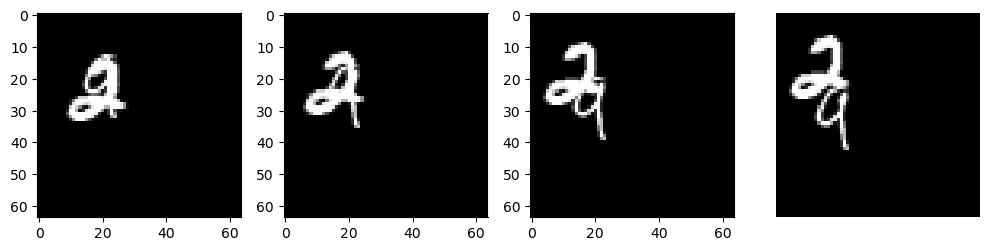

In [ ]:
all = [sample_x[0,i,:,:,0] for i in range(3)]+[sample_y[0,0,:,:,0]]
show_list(all)

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [ ]:
sample_x, sample_y = next(train_gen)

# The Model

The model I used is the following:<ul>
<li>4 <b>ConvLSTM2D</b> layers </li>
<li>3 <b>BatchNormalization</b> layers</li><li>1 <b>3D Convolution</b> layer</li><li>1 <b>Lambda/Reshape</b> layer</li>
</ul>
<br>

The Convolution Long Short-Term Memory layers serve the purpose of <b>learning long-term dependencies between time steps of data</b>. <br>The main difference with a normal LSTM layer is that the input and recurrent transformations are both 2 dimensional convolutional transformations.<br> This gives our model the <b>ability to interpret visual information in the form of 2D images</b> and the <b>ability to understand time sequences</b>, which is ideal for frame prediction.

<br>The BatchNormalization after each LSTM is used to <b>achieve a more stable and faster NN</b>, this is done by changing the distribution of the next layer such that the inputs of each layer have a mean of 0 and a unit variance.

<br>We then use a 3D Convolution to extract important visual features from the outputs of our ConvLSTM2D layers, notice that the <b>activation function is a sigmoid</b>, which allows to output video frames with pixels with brightness between 0 and 1.

The 3D Conv has as output 3 tensors, with various tests I noticed that the first 2 were always a worse blurred version of the last one, thus, to have a more precise computation of the MSE, I decided to remove the first 2 tensors and <b>base the computation only on the last one</b>.

<br>Lastly, the Lambda layer and the Reshape one are used to take into account only the last tensor of our network as said previously.


In [2]:
inp = layers.Input(shape=(3,64,64,1))
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(9, 9),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x=layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
x=layers.Lambda(lambda x: x[:,-1, :, :, :])(x)
x=layers.Reshape((1,64,64,1))(x)

# Next, we will build the complete model and compile it.
model5 = keras.models.Model(inp, x)

# Model Summary

Following the problems instructions, the metric is set to be <b>MSE</b>, while for the loss I opted for the <b>binary crossentropy</b>.

In [3]:
model5.summary()
model5.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=[keras.metrics.MeanSquaredError()],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 3, 64, 64, 64)     1348096   
                                                                 
 batch_normalization (BatchN  (None, 3, 64, 64, 64)    256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 3, 64, 64, 64)     819456    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 3, 64, 64, 64)     295168

# Hyperparameters and training
The hyperparameters we have to set are the <b>epochs</b> and the <b>batch_size</b>:<ul>
<li>The epochs are <b>40</b>, but it can be seen that after<b> epoch 25 the MSE score hardly undergoes major changes</b>. </li>
<li>The batch size is set to <b>16</b>, I tried both 32 and 8 as dimension for the batch, they were pretty similar, giving slightly better/worse results. I decided to use 16 batch-size to have a trade-off between the training time and the goodness of the result. </li>
</ul>

My final decision for hyperparameters was <b>mainly based on the computational power that I had</b>, the 40 epochs can be seen as an <b>"upper limit"</b>, because I found it pretty hard to go above them. Also, as stated before, 25 or a little more epochs could have reached a similar result.

Lastly, notice that to ease the computation and avoid overfitting <b>callbacks</b> were added to the algorithm.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_mean_squared_error", patience=5)

# Define modifiable training hyperparameters.
epochs = 40
batch_size = 16

# Fit the model to the training data.

model5.fit(x=train_gen,
          steps_per_epoch=len(trainset) // batch_size,
          epochs=epochs,
          validation_data=val_gen,
          validation_steps=len(valset) // batch_size,
          callbacks=[early_stopping,reduce_lr])

Epoch 1/40
500/500 [==============================] - 221s 404ms/step - loss: 0.0842 - mean_squared_error: 0.0202 - val_loss: 0.0938 - val_mean_squared_error: 0.0222 - lr: 0.0010
Epoch 2/40
500/500 [==============================] - 201s 402ms/step - loss: 0.0691 - mean_squared_error: 0.0154 - val_loss: 0.0693 - val_mean_squared_error: 0.0154 - lr: 0.0010
Epoch 3/40
500/500 [==============================] - 201s 403ms/step - loss: 0.0654 - mean_squared_error: 0.0140 - val_loss: 0.0660 - val_mean_squared_error: 0.0140 - lr: 0.0010
Epoch 4/40
500/500 [==============================] - 201s 403ms/step - loss: 0.0634 - mean_squared_error: 0.0133 - val_loss: 0.0627 - val_mean_squared_error: 0.0129 - lr: 0.0010
Epoch 5/40
500/500 [==============================] - 203s 405ms/step - loss: 0.0615 - mean_squared_error: 0.0126 - val_loss: 0.0616 - val_mean_squared_error: 0.0125 - lr: 0.0010
Epoch 6/40
500/500 [==============================] - 202s 405ms/step - loss: 0.0606 - mean_squared_error

# Results

The result for this model gives us a really good MSE, the <b>average is always < 0.01</b>, and if we print randomly predicted images we can see that it performs really well, as the predicted images is almost identical to the original one.

A better result could've been achieved probably with a bigger network, but I think that there would have been <b>no major improvements to the MSE</b> and the training time would've been prohibitive.

In [ ]:
test_loss = model5.evaluate(test_gen, steps=len(testset) // batch_size)
print("Test loss:", test_loss)

62/62 [==============================] - 9s 142ms/step - loss: 0.0507 - mean_squared_error: 0.0091
Test loss: [0.05068250745534897, 0.009059224277734756]


Printing the predicted image

1/1 [==============================] - 1s 920ms/step
(16, 1, 64, 64, 1)


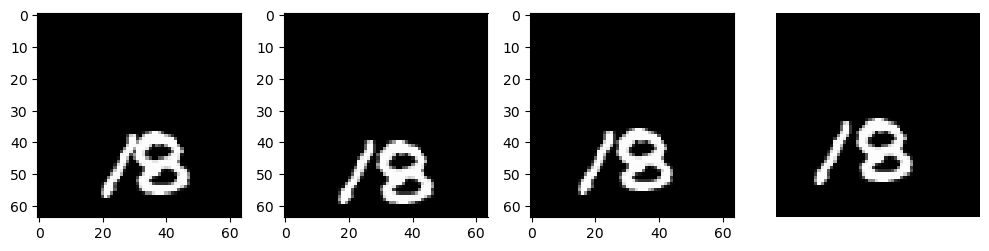

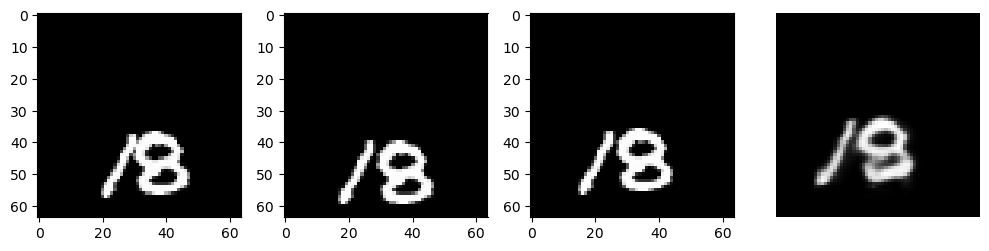

In [ ]:
sample_x,sample_y=next(test_gen)

new_prediction=model5.predict(sample_x)
print(new_prediction.shape)
all = [sample_x[0,i,:,:,:] for i in range(3)]+[sample_y[0,0,:,:,0]]
show_list(all)
all = [sample_x[0,i,:,:,:] for i in range(3)]+[new_prediction[0,0,:,:,0]]
show_list(all)

# Other models and results

The first model I tried was a simple <b> CNN </b> with various 2D convolution followed by Max Pooling layers, and 3 Dense layers at the end of it. This NN had a MSE which was around 0.02, the result wasn't too bad but neither too good compared to the other models. The main drawback of this model was that it <b>couldn't learn long-term dependecies</b>.
<br><br>
The second model was similar to the one I opted to use, the only difference was that there were <b>no Lambda/Reshape layers</b> and it had <b>1 less LSTM layer</b>, it had less than 1M parameters and it didn't go under 0.01 of MSE.  
<br>
The structure of this model was the one I used the most, I tried several iteration of it, adding and removing LSTM layers, changing the sizes of kernels/channels, and other changes.
<br><br>
At last, there was <b>one model that performed nearly as well as the one I adopted</b>, always using the same LSTM formula. The reason why I didn't use this one is simply because it had a <b>slightly worse MSE</b>.
<br>Below, you can find the code of the model.

In [ ]:
inp = layers.Input(shape=(3,64,64,1))
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
x=layers.Lambda(lambda x: x[:,-1, :, :, :])(x)
x=layers.Reshape((1,64,64,1))(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)

In [ ]:
model.summary()
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=[keras.metrics.MeanSquaredError()],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 3, 64, 64, 64)     815616    
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 3, 64, 64, 64)     819456    
                                                                 
 batch_normalization (BatchN  (None, 3, 64, 64, 64)    256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 3, 64, 64, 64)     295168    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                             